Getting familiar with virtual adversarial training. 

In [59]:
# A torch implementation of VAT.
import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

@contextlib.contextmanager
def _disable_tracking_bn_stats(model):
    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)
    
def normalize(d):
    d /= (torch.sqrt(torch.sum(d**2, axis=1)).view(-1,1)+1e-16)
    return d

def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-16
    return d

def _kl_div(p,q):
    '''
    D_KL(p||q) = Sum(p log p - p log q)
    '''
    logp = torch.nn.functional.log_softmax(p,dim=1)
    logq = torch.nn.functional.log_softmax(q,dim=1)
    p = torch.exp(logp)
    return (p*(logp-logq)).sum(dim=1,keepdim=True).mean()

class VATLoss(nn.Module):
    def __init__(self, xi = .0001, eps = 0.1, ip = 2):
        """
        :xi: hyperparameter: small float for finite difference threshold 
        :eps: hyperparameter: value for how much to deviate from original X.
        :ip: value of power iteration for approximation of r_vadv.
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip
        
    def forward(self, model, x):
        with torch.no_grad():
            pred = model(x)
        
        # random unit tensor for perturbation
        d = torch.randn(x.shape)
        d = _l2_normalize(d)
        #calculating adversarial direction

        for _ in range(self.ip):
            d.requires_grad_()
            pred_hat = model(x + self.xi * d)
            adv_distance = _kl_div(pred_hat, pred)
            adv_distance.backward()
            d = _l2_normalize(d.grad.data)
            model.zero_grad()
        
        r_adv = d*self.eps
        pred_hat = model(x+r_adv)
        lds = _kl_div(pred_hat, pred)
        return lds

In [60]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(2,100)
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100,100)
        self.linear4 = nn.Linear(100,2)
        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

Visualizing VAT with sklearn.moon.

In [61]:
import torch.utils.data
import torch.nn.functional as F

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.metrics import accuracy_score

In [62]:
X_all, y_all = sklearn.datasets.make_moons(n_samples=1000,shuffle=False,noise=0.1,random_state=41)
X0_all = X_all[y_all==0]
X1_all = X_all[y_all==1]
i_labeled = 400
half_n_labeled = 4

X0u = X0_all.copy()
X1u = X1_all.copy()

Xl, yl = sklearn.datasets.make_moons(n_samples=3*half_n_labeled,shuffle=False,noise=0.1,random_state=9)
X0l = Xl[yl==0][:half_n_labeled]
X1l = Xl[yl==1][:half_n_labeled]
Xl_new = np.r_[X0l,X1l]
yl_new = np.array([0,0,0,0,1,1,1,1])

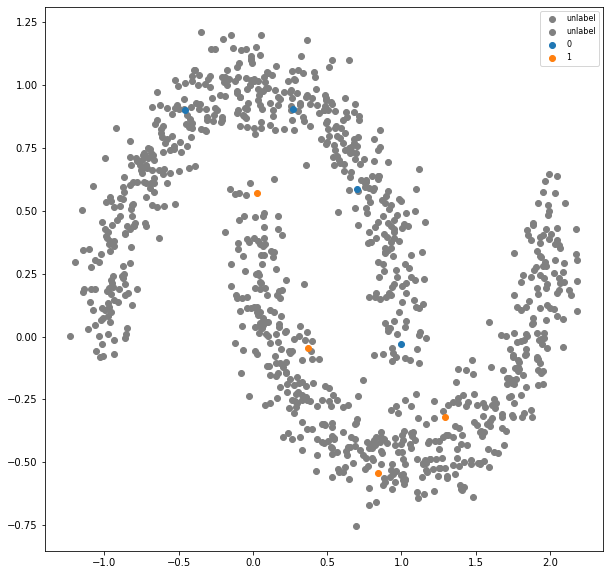

In [63]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
ax.scatter(X0u[:,0],X0u[:,1],c='gray',label='unlabel')
ax.scatter(X1u[:,0],X1u[:,1],c='gray',label='unlabel')
ax.scatter(X0l[:,0],X0l[:,1],c='C0',label='0')
ax.scatter(X1l[:,0],X1l[:,1],c='C1',label='1')
ax.legend(loc='upper right', bbox_to_anchor=(1,1), fontsize=8)

In [64]:
def train(u):
    vat_loss=VATLoss(ip=2,xi=0.5,eps=0.5)
    cross_entropy = nn.CrossEntropyLoss()
    lds = vat_loss(model,u.float())
    output = model(torch.tensor(Xl_new).float())
    classification_loss = cross_entropy(output, torch.tensor(yl_new))
    loss = classification_loss + 4.*lds
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return classification_loss, lds

def valid(win=None):
    model.eval()
    z_pred = torch.nn.functional.softmax(model(torch.from_numpy(X_all).float()),dim=1).data.numpy()[:,1]
    val = np.c_[X_all,z_pred.T]
    
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(111)
    h = ax.scatter(X_all[:,0],X_all[:,1], c=z_pred, vmin=0, vmax=1,cmap='seismic')
    ax.scatter(X0l[:,0],X0l[:,1],c='C0',marker='s',s=100)
    ax.scatter(X1l[:,0],X1l[:,1],c='C1',marker='v',s=100)
    fig.colorbar(h)
    return win,val

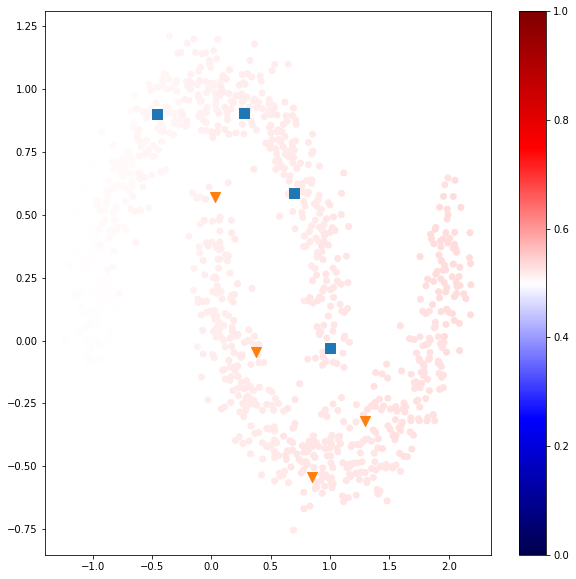

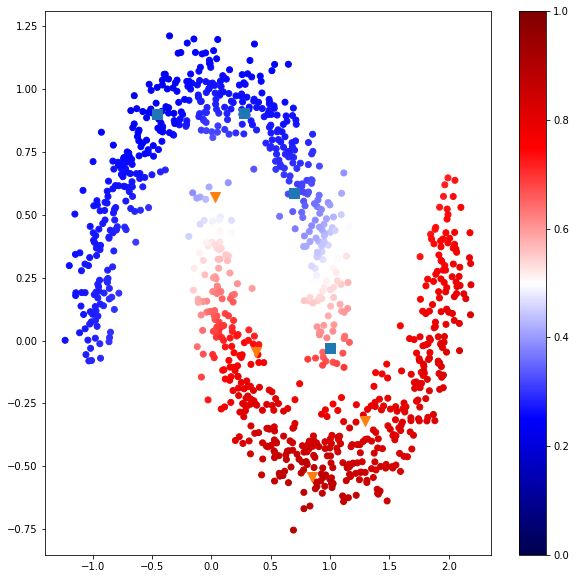

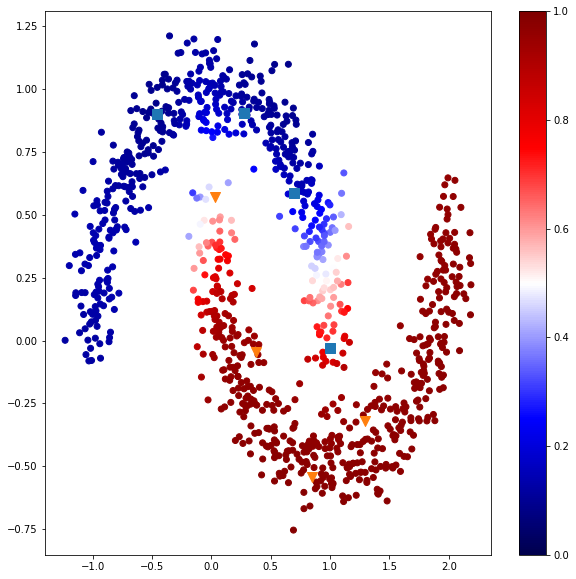

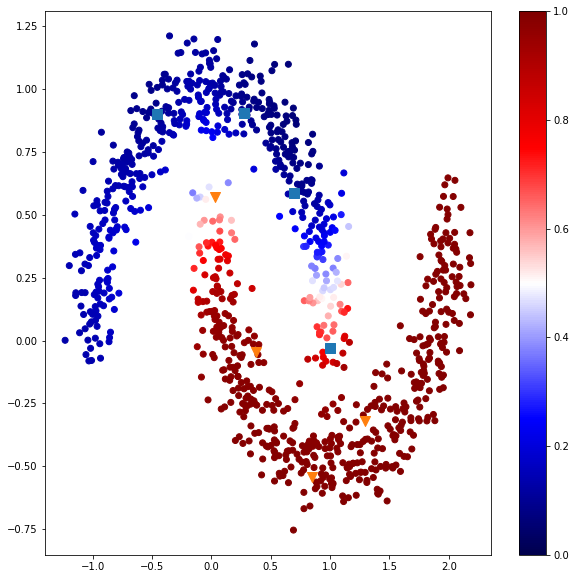

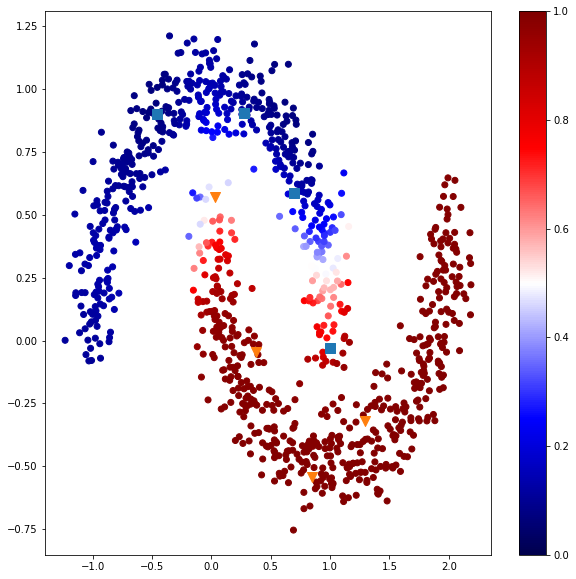

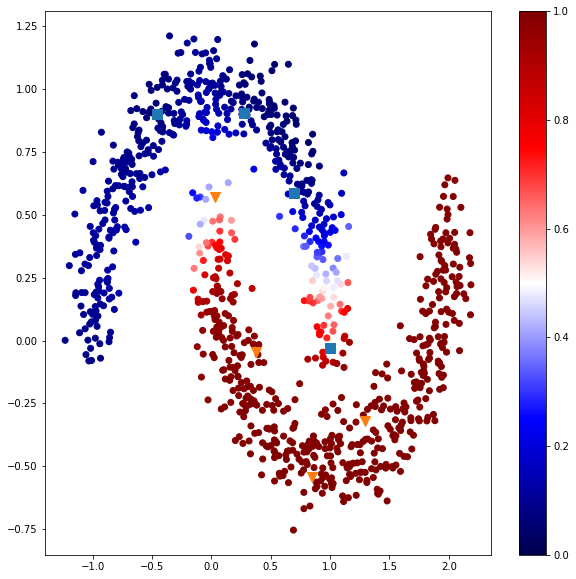

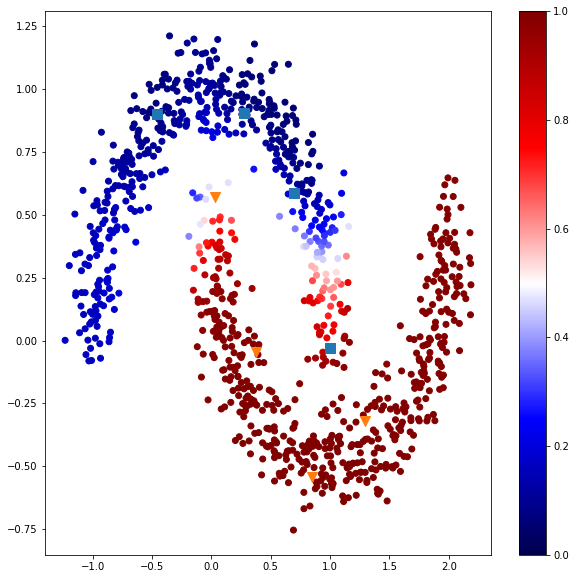

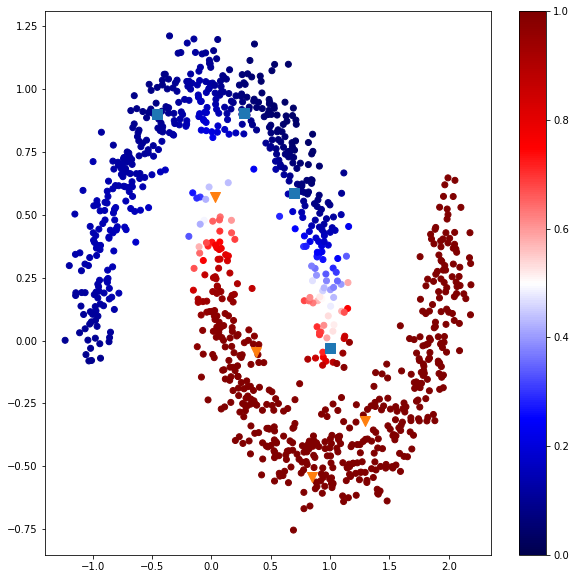

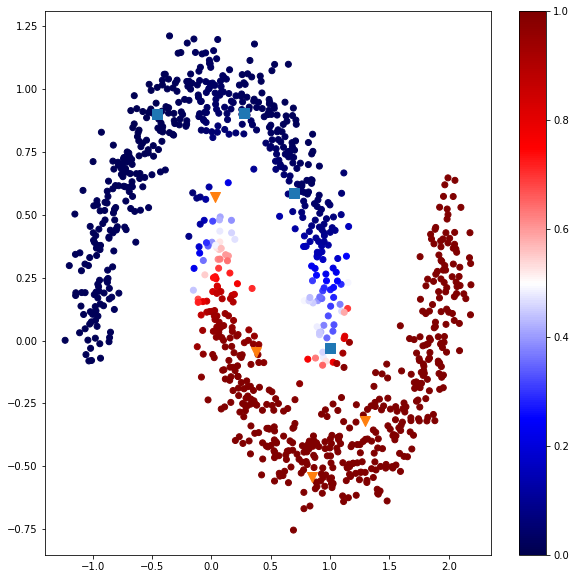

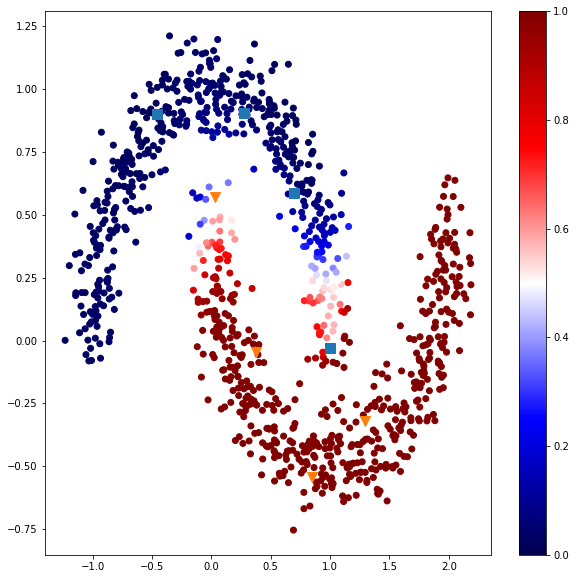

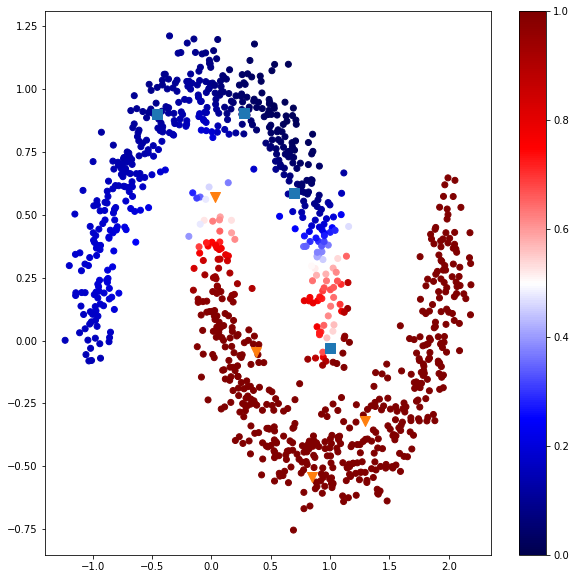

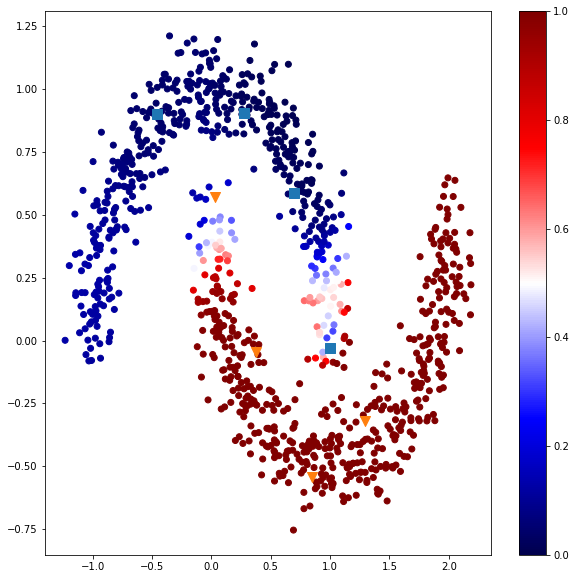

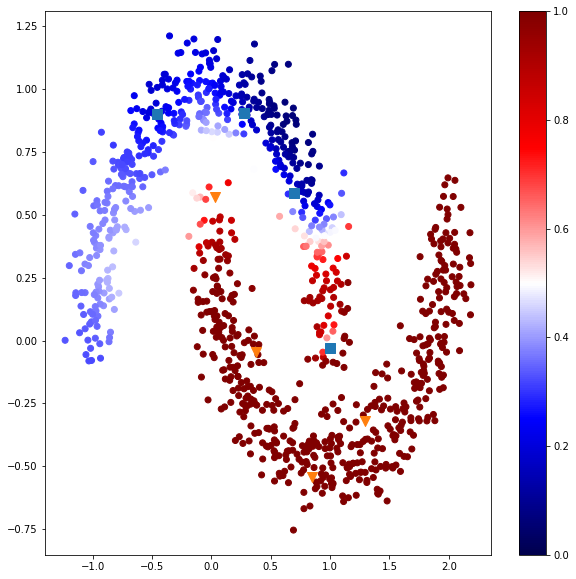

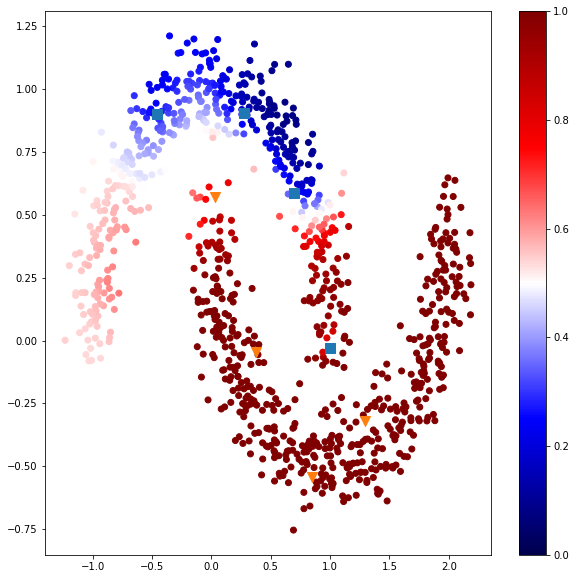

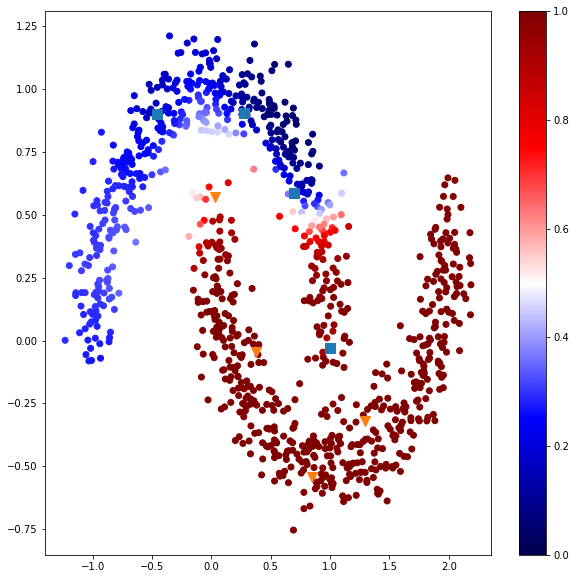

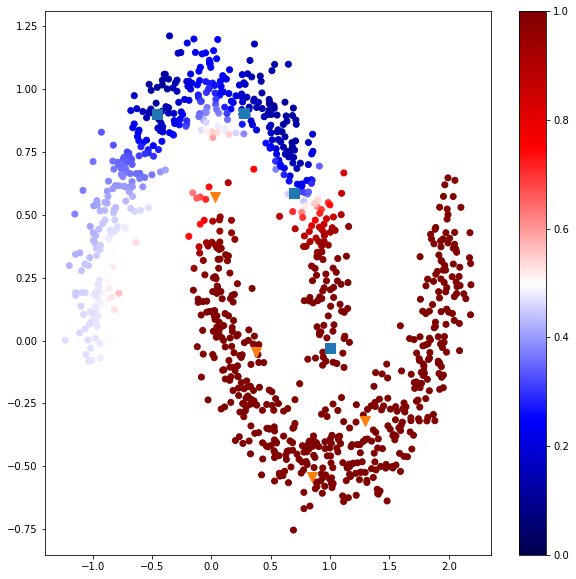

In [65]:
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.001)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_all),torch.LongTensor(y_all))
win = None
picdata = []
for epoch in range(150):
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
    for u , _ in dataloader:
        i_total_step +=1
        classification_loss, lds = train(u)

        ce_losses =classification_loss.item()
        vat_losses = lds.item()
        if i_total_step%100 == 0 or i_total_step==1:
            win, dat = valid(win)
            picdata.append(dat);

In [71]:
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3, eps=1e-3)
gamma = 4e1

var = torch.autograd.Variable
ftn = torch.FloatTensor
ltn = torch.LongTensor
dataset = torch.utils.data.TensorDataset(ftn(X_all), ltn(y_all))


for i in range(150):#epoch
    data_loader = torch.utils.data.DataLoader(dataset, 121, shuffle=True) #batch size 
    for u, _ in data_loader:
        i_total_step += 1
        vat_loss = VATLoss()
        cross_entropy = nn.CrossEntropyLoss()
        lds = vat_loss(model, torch.tensor(u).float())
        output = model(torch.tensor(Xl).float())
        classification_loss = cross_entropy(output, torch.tensor(yl))
        loss = classification_loss + gamma * lds
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        accuracy = accuracy_score(yl,np.argmax(output.data.numpy(),axis=1))
        ce_losses = classification_loss.item()
        vat_losses = gamma*lds.item()
        if i_total_step % 200 == 0:
            print("CrossEntropyLoss %f:" % (ce_losses))
            print("VATLoss %f:" % (vat_losses))
            print("Accuracy %f:" % (accuracy)) 
            print("---------------------------------")


<ipython-input-71-9144f3e37315>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lds = vat_loss(model, torch.tensor(u).float())


CrossEntropyLoss 0.143019:
VATLoss 0.369373:
Accuracy 0.916667:
---------------------------------
CrossEntropyLoss 0.501339:
VATLoss 3.999674:
Accuracy 0.916667:
---------------------------------
CrossEntropyLoss 0.000251:
VATLoss 2.581309:
Accuracy 1.000000:
---------------------------------
CrossEntropyLoss 0.000061:
VATLoss 1.360273:
Accuracy 1.000000:
---------------------------------
CrossEntropyLoss 0.000040:
VATLoss 1.752195:
Accuracy 1.000000:
---------------------------------
CrossEntropyLoss 0.000039:
VATLoss 2.003534:
Accuracy 1.000000:
---------------------------------


In [84]:
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all))), dim=1).data.numpy()[:, 1]
z_pred = np.where(z_pred > 0.5, 1, 0)
print("{0} vat acc".format(accuracy_score(y_all, z_pred)))


0.997 vat acc


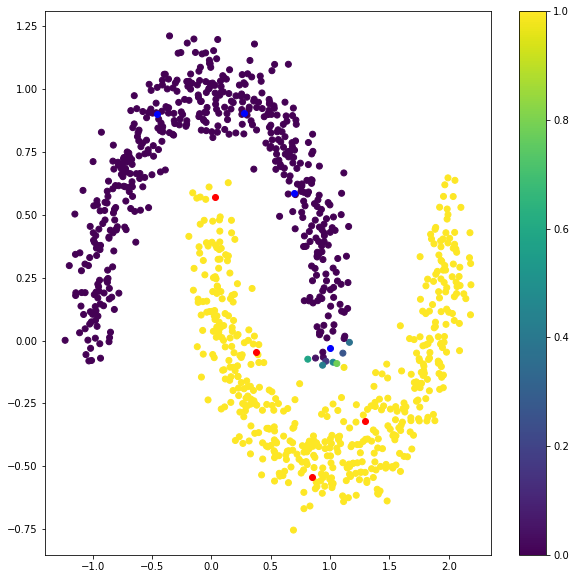

In [90]:
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
z_pred = torch.nn.functional.softmax(model(var(ftn(X_all))), dim=1).data.numpy()[:, 1]
h = ax.scatter(X_all[:, 0], X_all[:, 1], c=z_pred, zorder=-1)
ax.scatter(X0l[:, 0], X0l[:, 1], c="blue", zorder=1)
ax.scatter(X1l[:, 0], X1l[:, 1], c="red", zorder=1)
fig.colorbar(h)

In [74]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [78]:
svm = SVC()
svm.fit(Xl, yl)
Y_pred = svm.predict(X_all)
print("{0} SVM acc".format(accuracy_score(y_all, Y_pred)))

0.883 SVM acc


In [79]:
rf = RandomForestClassifier()
rf.fit(Xl, yl)
Y_pred = rf.predict(X_all)
print("{0} RF acc".format(accuracy_score(y_all, Y_pred)))

0.895 RF acc


Also worth looking into this guys implementation: https://github.com/9310gaurav/virtual-adversarial-training/blob/master/model.py 

Next step: run this with dbpedia vectors, convert vectors to words using embeddings file and see how accurately it classifies text. 